## - This is notebook loads the TPU model and can then generates predictions for sequences and use this to evaluate its performance


### - The saved model weights for the TPU model can be found on Zenodo (Complex Media : https://zenodo.org/record/4436477/files/complex_media_fitness_function.h5?download=1 , Defined Media : https://zenodo.org/record/4436477/files/defined_media_fitness_function.h5?download=1) in addition to the directories referenced in the code (accessible from CodeOcean and the GCP vm)

#### Important Note for the Reviewers and Readers : 
- Our test datasets in the manuscript (for example the ones used in Fig. 1b,c, Extended Data Fig. 2, Supplementary Fig. 4, etc. ) are not simply held-out subsets of the training datasets. They are separate test datasets generated as part of completely independent experiments with lower-complexity (~1000 fold lower sequence diversity) libraries than the large-scale training data generation experiments resulting in expression measurements with a low measurement-error. The test data used here can be found in the `../../../data/test_data/` folder relative to this notebook's current directory.
- Since the training data and the test data are collected in different experiments, the units of expression are on different unrelated scales (the units are arbitrary units local to experiments and not absolute comparable units across experiments) because of the nature of GPRA/Sort-seq experiments.


### Imports

In [1]:

import sys
import rr_aux
from rr_aux import *
#%load_ext autoreload
#%autoreload 2
##Clear Memory 
tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()
##

rcParams['pdf.fonttype'] = 42


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3

### Load TPU model 
Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency. But, simply changing the model_conditions variable below should allow the user to the load the defined media model.

In [2]:
model_conditions='Glu' # options : 'Glu'# 'Glu' refers to complex media, 'SC_Ura' refers to defined media

NUM_GPU = len(get_available_gpus())
if(NUM_GPU>0) :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

print(tf.__version__)
print(keras.__version__)
#tpu_grpc_url = TPUClusterResolver(tpu=['edv-tpu2'] , zone='us-central1-a').get_master()




### Load the Model in a separate graph here as there are two models in this figure.
fitness_function_graph = tf.Graph()
with fitness_function_graph.as_default():
    model, scaler,batch_size = load_model(model_conditions)

1.14.0
2.2.4-tf


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



# Random Test Data (corresponding to Fig. 1b)

### Load random test data (corresponding to Fig. 1b)

#####  ‘Random Test Data’ definition: 
The test data corresponding to Figure 1a. This test dataset is a a fresh random sample of sequences from the complete sequence space whose expression is measured in the complex medium separately of the training data generation experiment allowing for high quality expression measurements. 


In [3]:

def read_hq_testdata(filename) :
    #### Convert sequence to one hot code and return sequence, expression pairs
    with open(filename) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)

    sequences = [di[0] for di in d]

    
    for i in tqdm(range(0,len(sequences))) : 
        if (len(sequences[i]) > 110) :
            sequences[i] = sequences[i][-110:]
        if (len(sequences[i]) < 110) : 
            while (len(sequences[i]) < 110) :
                sequences[i] = 'N'+sequences[i]


    expressions = [di[1] for di in d]
    expdata = np.asarray(expressions)
    expdata = expdata.astype('float')  

    return np.squeeze(np.asarray(sequences)),expdata

sequences,expressions = read_hq_testdata(os.path.join('../../../data/test_data/HQ_testdata.txt'))
expressions = [float(x) for x in expressions]


100%|██████████| 9982/9982 [00:00<00:00, 1802304.89it/s]


### Generate expression predictions using the TPU model

In [4]:
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

10240/10240 [==============================] - 12s 1ms/sample


### Compute and Print the Pearson's r between Measured and Predicted expression


In [5]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Random test data is', format(pcc, '0.3f'))

### Uncomment the next line to get the Pearson's r for more decimal places
#print(f'The Pearson\'s r for the Random test data is', format(pcc)) ### Keen readers will note that this value was used in Notebook 3 of the benchmarking models


The Pearson's r for the Random test data is 0.981


#### Plot the scatterplot to visualize the prediction performance ( this result is the same as Fig. 1b)


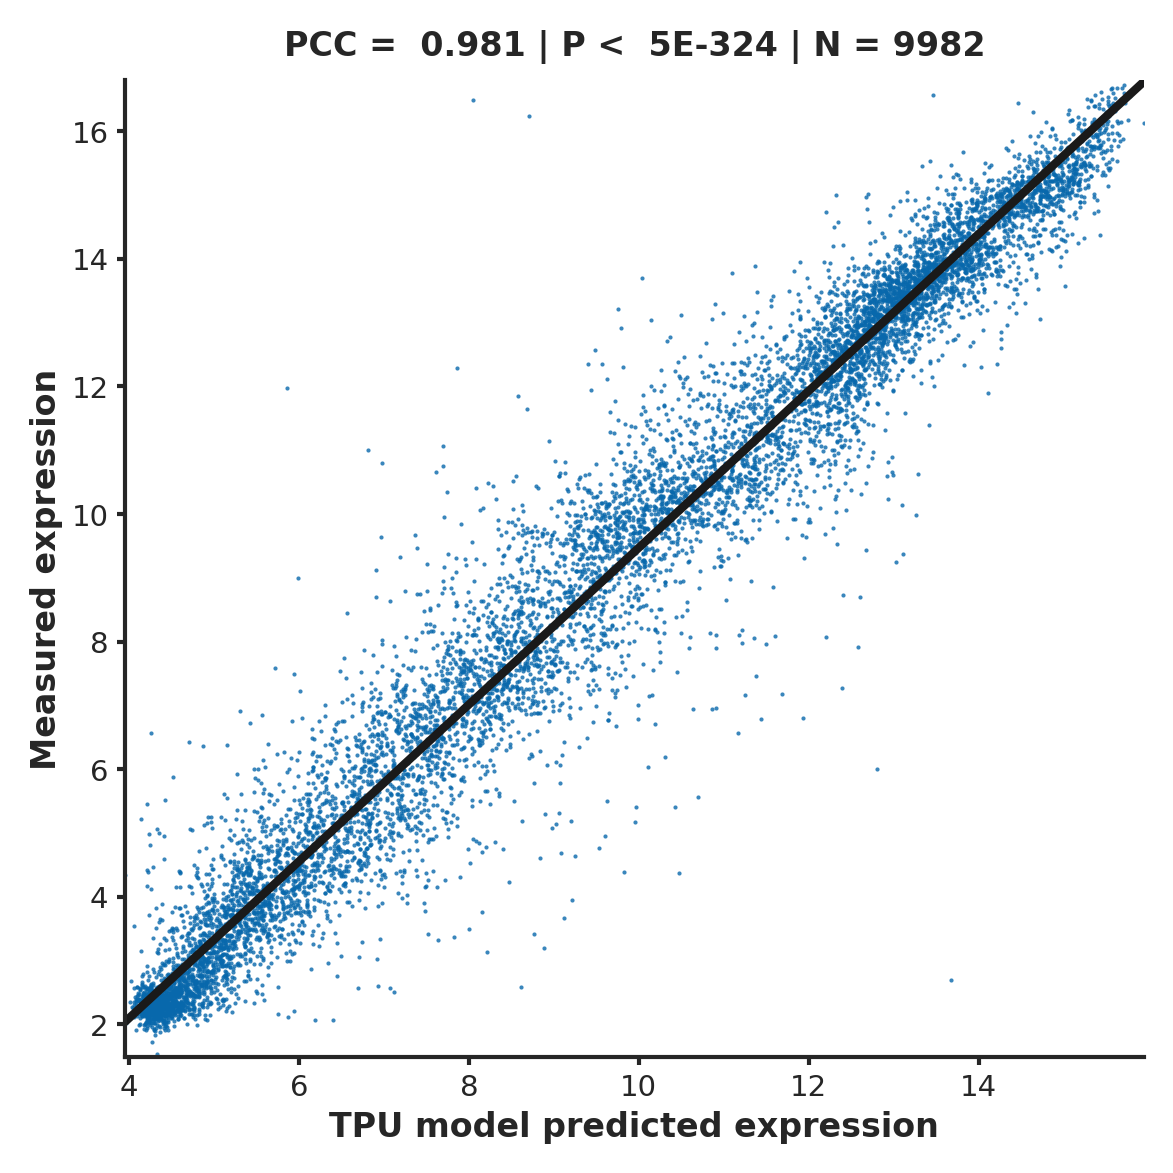

In [11]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [12]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Random_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,NNNNNNNNNNTGCATTTTTTTCACAAGAGCACTTGAAGGGCGCCTA...,13.708592,13.144622
1,NNNTGCATTTTTTTCACACATATACTTGGGTGACTTAGATATTTGC...,2.553335,4.590216
2,NTGCATTTTTTTCACACATCTGGATTGTCTGGTGTGCTGGTATCTT...,13.369969,13.149384
3,NTGCATTTTTTTCACACCACCGTGGGGATTCGCAGCTATGTGCATA...,3.328683,5.131679
4,NNTGCATTTTTTTCACACCATGGATTTAAGAATTAATCACCGGACA...,10.466688,11.301416
...,...,...,...
9977,NNTGCATTTTTTTCACTCTTTCACGTGGGGCCTGCGGGGTATCGGT...,14.962475,15.238556
9978,NNNNNNNNNNNNTGCATTTTTTTCACTGATGTGGTGCGCGTAATTT...,11.999880,13.480228
9979,TGCATTTTTTTCACTTCCAGTAATATGCGAAAGGGTGATGTGAACT...,4.541188,6.266724
9980,NNNNNNNNNNNNNNTGCATTTTTTTCACTTCGCACTCCACTTCTCG...,7.456650,11.376089


# Native Test Data (corresponding to Fig. 1c)


### Load native test data (corresponding to Fig. 1c)

#####  ‘Native Test Data’ definition: 
The test data corresponding to Figure 1c. This test dataset corresponds to a set of native yeast promoter sequences from the S288C reference genomes measured in the complex medium. As above, they are measured in an experiment separate from the large training data generation experiment. 



In [13]:
native_df = pd.read_csv('../../../data/test_data/Native_testdata.csv', index_col = 0 )

### Generate expression predictions using the TPU model


In [14]:
sequences = list(native_df.seq110.values) ### sequence
expressions= list(native_df.meanEL) ### measured expression


### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

4096/4096 [==============================] - 5s 1ms/sample


### Compute and Print the Pearson's r between Measured and Predicted expression


In [15]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Native test data is', format(pcc, '0.3f'))


The Pearson's r for the Native test data is 0.961


### Plot the results (this result is the same as Fig. 1c )

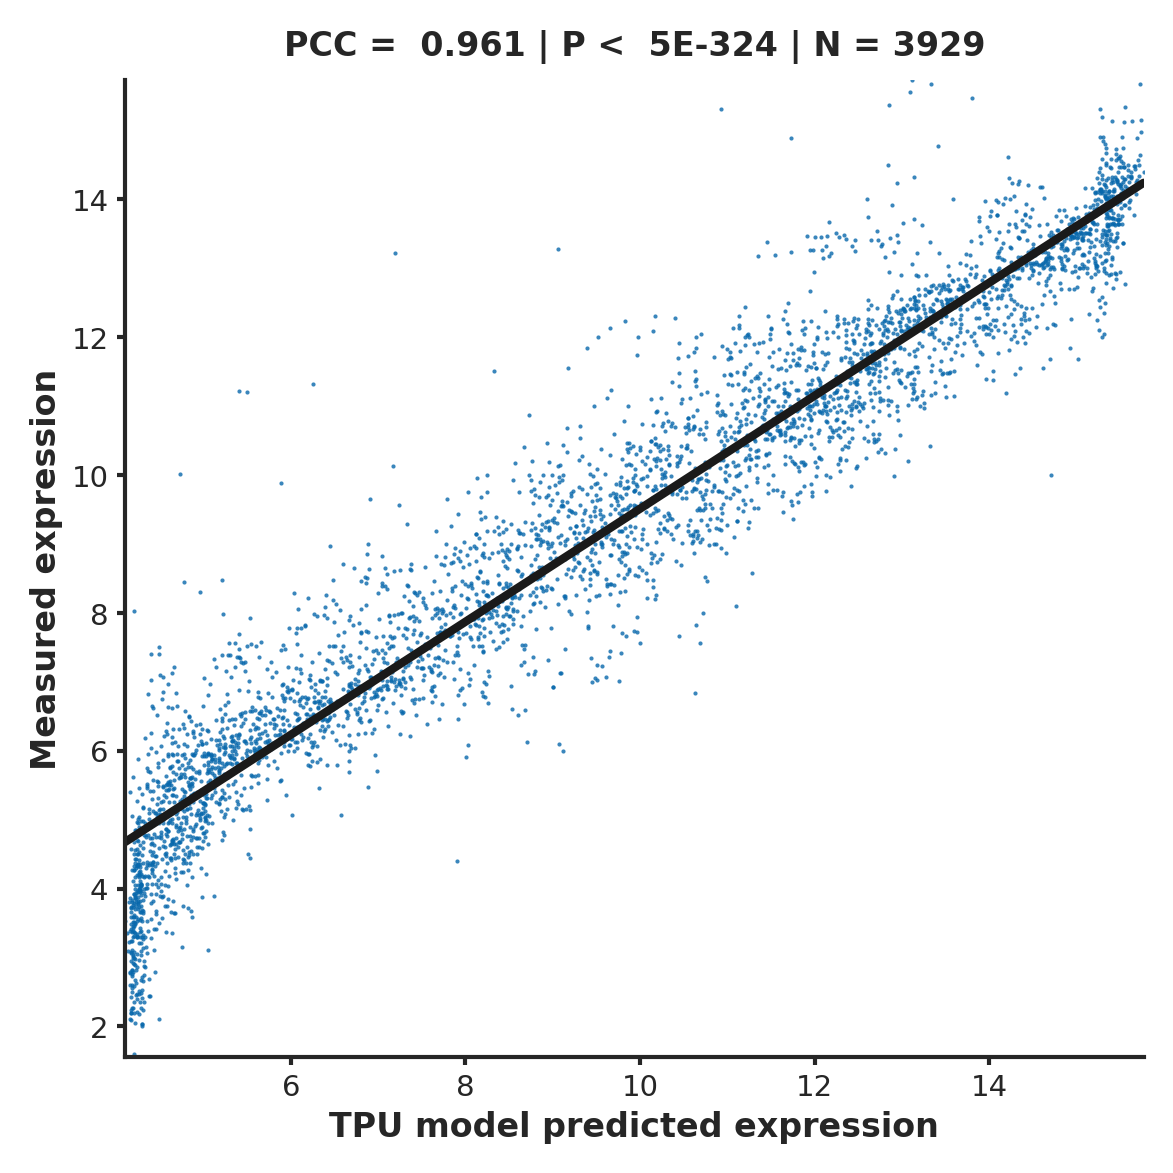

In [16]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_native"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [17]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Native_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGG...,13.168816,14.333738
1,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAACAAAAAGG...,13.457919,14.332550
2,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGA...,13.855758,14.495706
3,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,12.043120,13.306715
4,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,13.529583,14.713246
...,...,...,...
3924,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.344921,7.655699
3925,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,6.589246,5.922864
3926,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.740563,6.864065
3927,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCCTTATTCT...,7.421802,6.316618


# Reproduce the random mutational drift validation experiment prediction result (Extended Data Fig. 2j) corresponding to Figure  2a-c using the TPU model's predictions

Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency. 

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own. 
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets
##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [18]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to random drift in the complex medium
    fig_df = snp_df.loc[(snp_df.rand) & (snp_df.expt=='NBT_S288CdU_YPD')] #(snp_df.randMut) &

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/Drift_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/Drift_testdata.csv' , index_col =0)

### Generate expression predictions using the TPU  model

In [20]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL.mut'].values) # Load expressions

### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

3072/3072 [==============================] - 4s 1ms/sample


### Compute and Print the Pearson's r between Measured and Predicted expression

In [21]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Random Drift test data (corresponding to the section for Fig 2a-c) is', format(pcc, '0.3f'))


The Pearson's r for the Random Drift test data (corresponding to the section for Fig 2a-c) is 0.974


### Plot the results ( same as Extended Data Fig. 2j)
Readers familiar with the biorxiv version of our manuscript will notice that the value of N in the final version is half the value of N in the biorxiv version. This is was our mistake ( we combined two dataframes previously when making this plot, and used the combined df to compute the N instead of the original one). This has been corrected and the correct version of N is shown in the final version (and below). This did not affect the Pearson's r calcultion of the P value in any way ( and the readers will notice that it remains the same - those were computed independently of the N, as shown below)

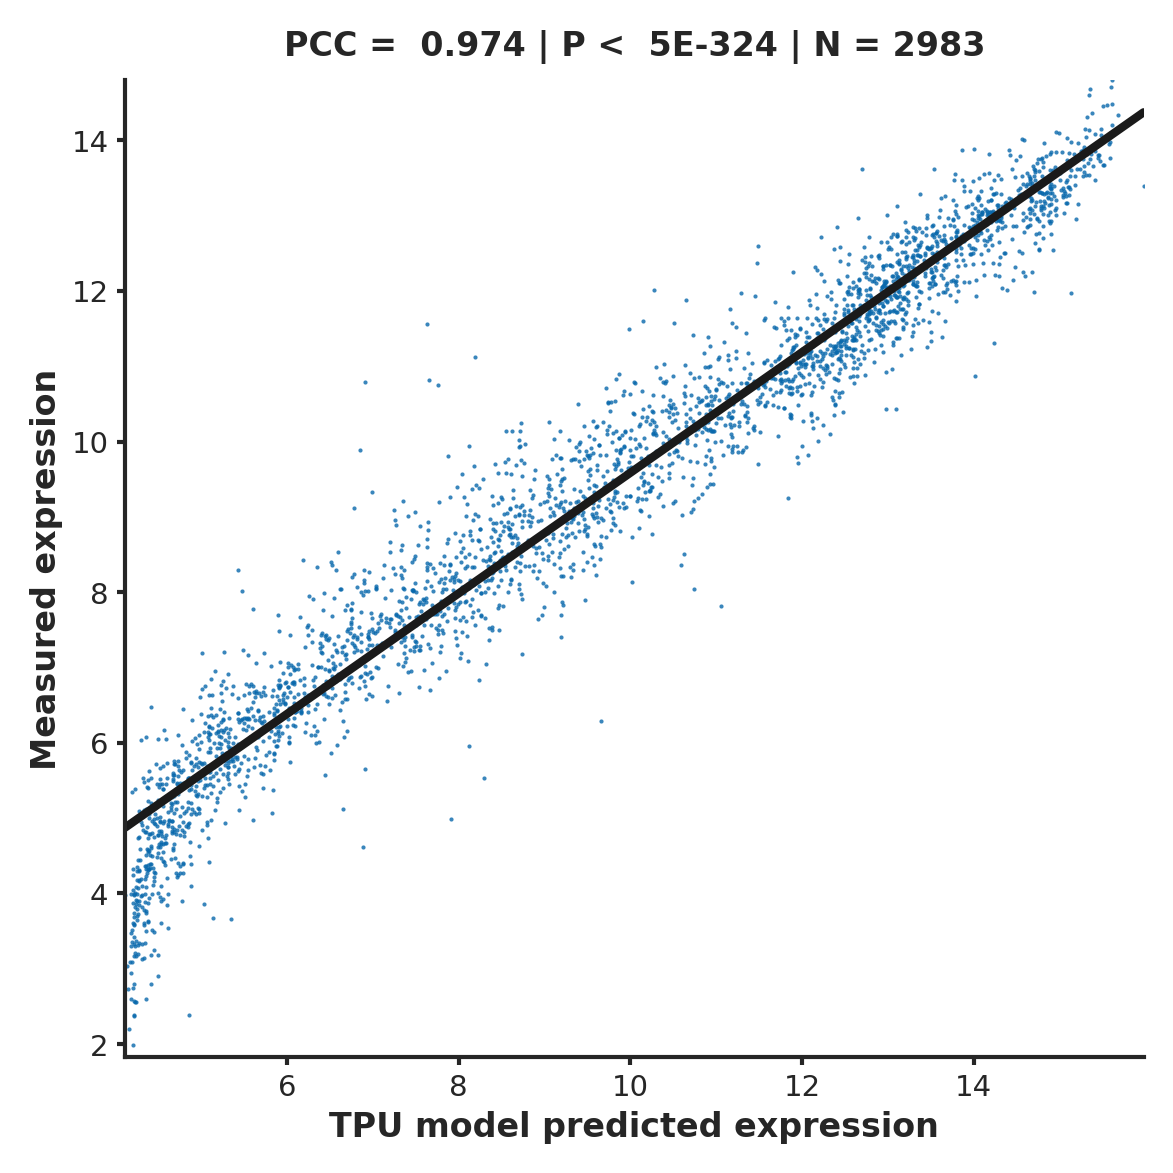

In [22]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_drift"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [24]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Drift_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACGGCGC...,11.278011,12.921628
1,TGCATTTTTTTCACATCCTTTAAATTCGGTGGGGACGCGTCGGCGC...,11.725461,13.208659
2,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACCGCGC...,11.725053,13.091141
3,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGAGGACAGTC...,9.008385,10.215848
4,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGACGACAGTC...,10.695459,11.634071
...,...,...,...
2978,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTATGAATATCGTAAC...,12.134682,13.292812
2979,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTACGAGTATCGTAAC...,13.562228,14.617356
2980,TGCATTTTTTTCACATCGGAACGTTAACATCAATCCGGTCACCACG...,10.788450,11.057049
2981,TGCATTTTTTTCACATCGGAACGTTAATATCCATCCGGTCACCACG...,12.423164,13.211720


# Reproducing the SSWM validation experiment prediction result (Extended Data Fig. 2i) corresponding to Figure  2e-g using the TPU model's predictions 

Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media TPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [25]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to SSWM in the complex medium
    
    fig_df =full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')]
    fig_df.loc[fig_df.trajDir=='dec' , 'trajDir'] = 'min'
    fig_df.loc[fig_df.trajDir=='inc','trajDir'] = 'max'

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/SSWM_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/SSWM_testdata.csv' , index_col =0)

### Generate expression predictions using the TPU only model


In [27]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

11264/11264 [==============================] - 14s 1ms/sample


### Compute and Print the Pearson's r between Measured and Predicted expression

In [28]:

pcc = scipy.stats.pearsonr(predicted_expresbsions,expressions)[0]
print(f'The Pearson\'s r for the SSWM test data (corresponding to the section for Fig 2e-f) is', format(pcc, '0.3f'))


The Pearson's r for the SSWM test data (corresponding to the section for Fig 2e-f) is 0.981


### Plot the results 

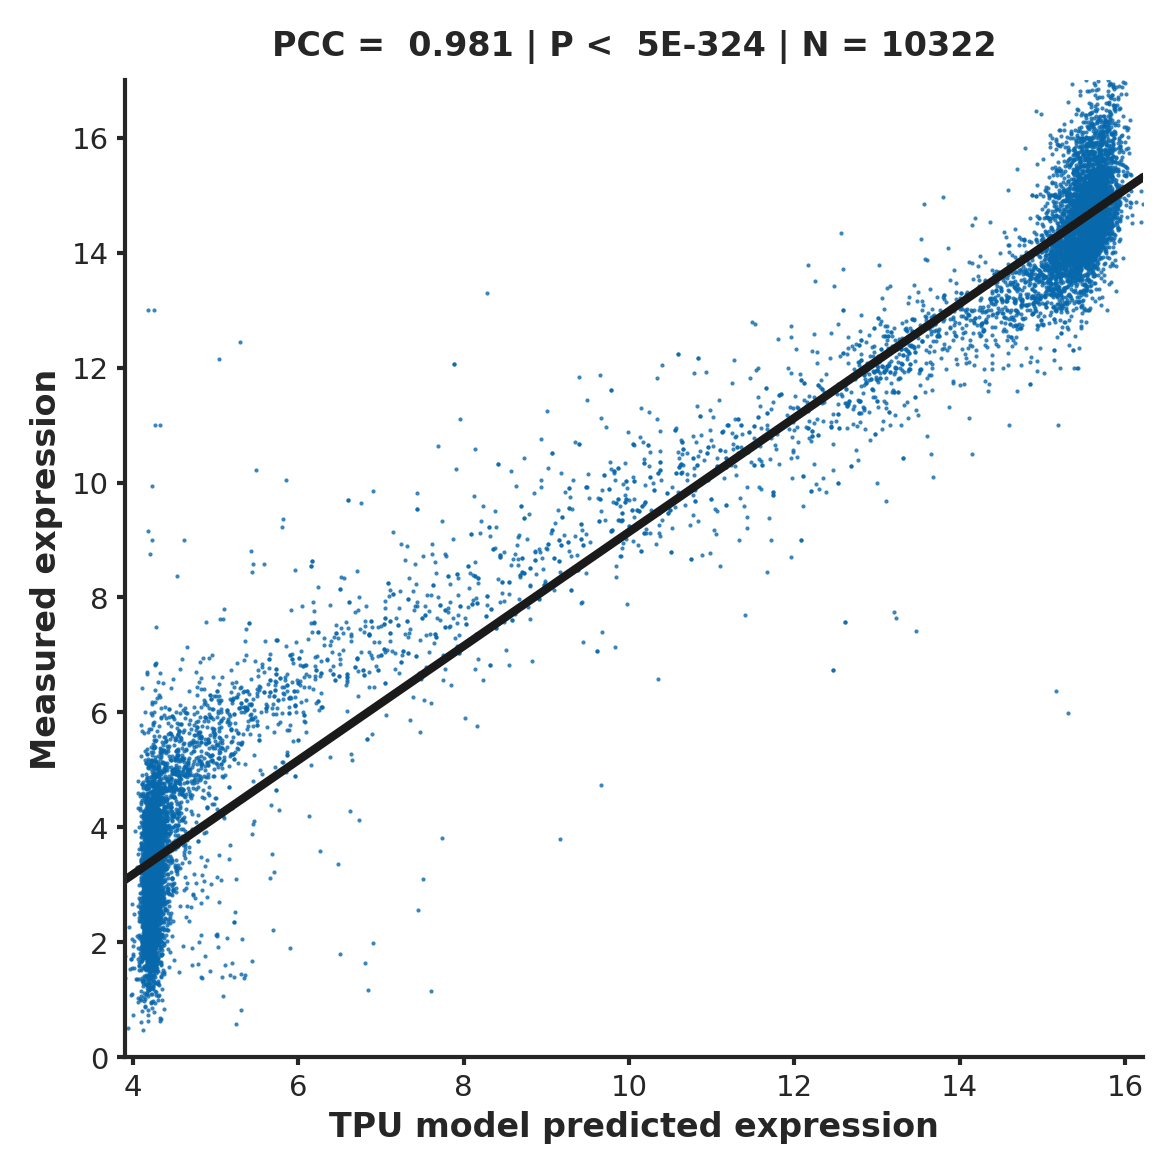

In [29]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_sswm"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [30]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/SSWM_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.353749
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,14.000000,15.208617
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.000000,15.420066
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.783623,15.327061
...,...,...,...
10317,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,15.644227,15.528503
10318,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.604007,15.545308
10319,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.581721,15.556981
10320,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,13.727267,15.543314


# Prediction results corresponding to Figure 1d (the Genetic Algorithm panel ) using the TPU model's predictions vs the measured expression 

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [31]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to random drift in the complex medium


    fig_df = full_df[(full_df.expt=='NBT_S288CdU_YPD') &   
                              (full_df.designedCond=='Glu')&  
                              (full_df.designed==1)]

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/ga_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/ga_testdata.csv' , index_col =0)

### Generate expression predictions using the GPU only model

In [32]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

1024/1024 [==============================] - 1s 1ms/sample


In [33]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Genetic Algorithm test data (corresponding to the section for Fig 1d) is', format(pcc, '0.3f'))


The Pearson's r for the Genetic Algorithm test data (corresponding to the section for Fig 1d) is 0.993


### Plot the results 

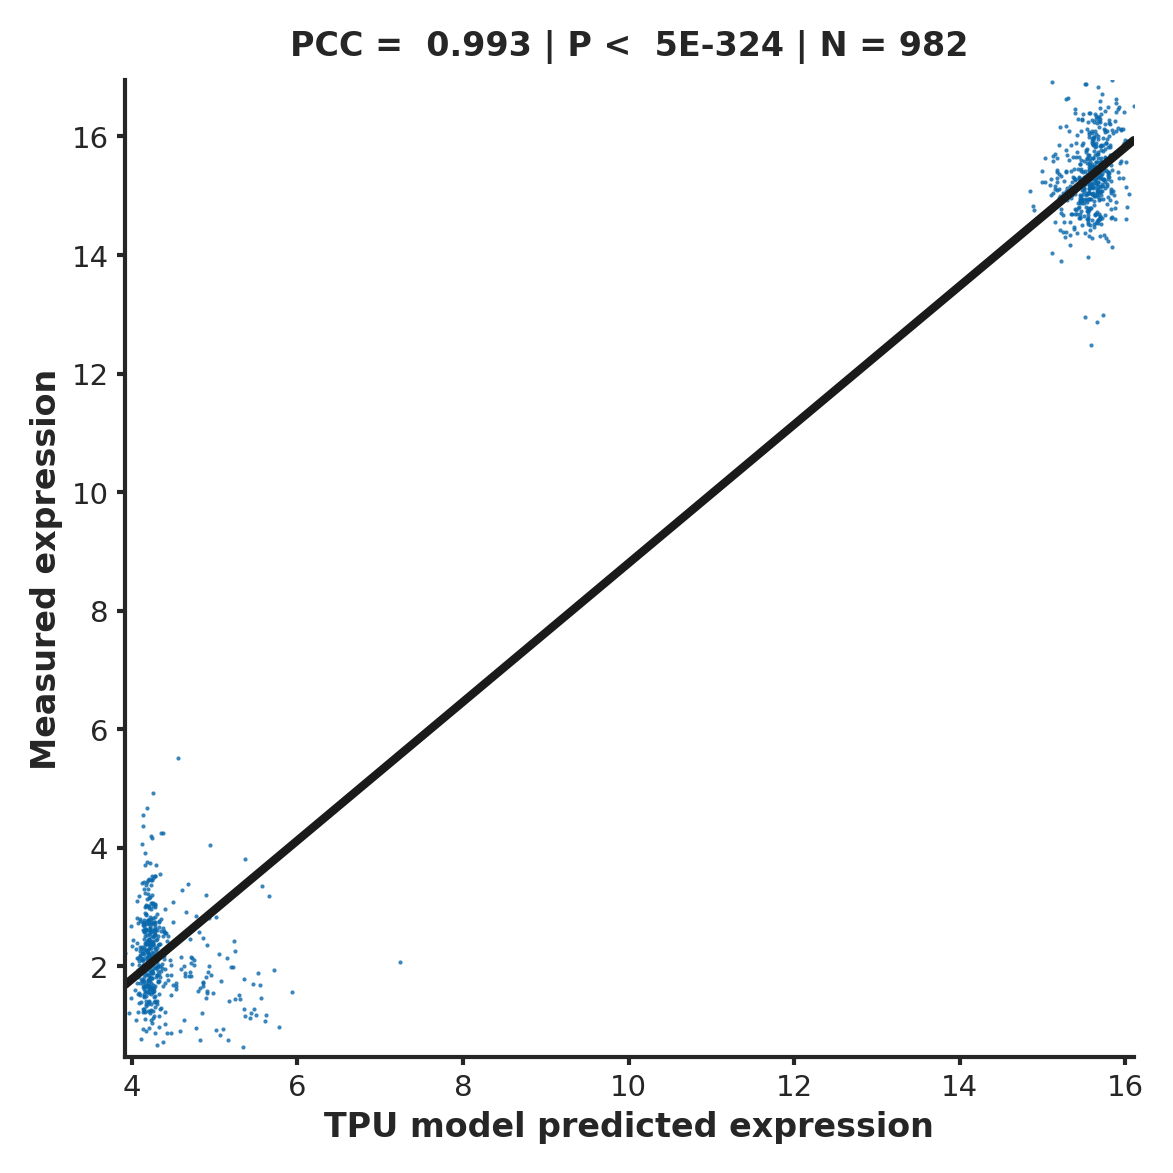

In [35]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_ga"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [36]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/ga_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAGGCTATTTGATATGTTAAAAGAAGG...,1.244706,4.143212
1,TGCATTTTTTTCACATCAAACAATCTCTTGATGTGTCAGAAATAAG...,0.980188,4.331097
2,TGCATTTTTTTCACATCAAACAATGGGTTGTCATCTTCTAAGATAG...,2.764484,4.326525
3,TGCATTTTTTTCACATCAAACTATTGTTAGATGTCAAATGAACTAC...,1.414264,4.208059
4,TGCATTTTTTTCACATCAAACTCTATCATTTCTGCAGAGGTTGCAA...,2.241734,4.199040
...,...,...,...
977,TGCATTTTTTTCACATCTTTTGATATAACCTGGTCGAATATACTAT...,3.232783,4.162705
978,TGCATTTTTTTCACATCTTTTGCAACTATTTCACCAAATGGTATCC...,3.432195,4.147635
979,TGCATTTTTTTCACATCTTTTGTAATAGTAGATGTCAATGGGATAG...,3.305018,4.145849
980,TGCATTTTTTTCACATCTTTTTCCGGGTGACGGCGCGACTTTGTGC...,15.260873,15.632592


# Gini Trajectories

### Save Results

In [3]:
import glob
file_list = glob.glob('../../../data/test_data/all_gini_trajectories/*')[:-1]



for i in [-1,1,-2,2,0]: 
    gini_df = pd.read_csv( file_list[i], 
                          sep='\t')
    sequences = population_add_flank(list(gini_df['N80seq'].values))
    expressions = gini_df['meanEL_NBT_S288CdU_YPD'].values
    predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)


    results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})

    results_df.to_csv('../../../results_summary/'+file_list[i].split('/')[-1]+'_tpu_model.csv')

1024/1024 [==============================] - 1s 1ms/sample


### Plot Results

1024/1024 [==============================] - 1s 1ms/sample


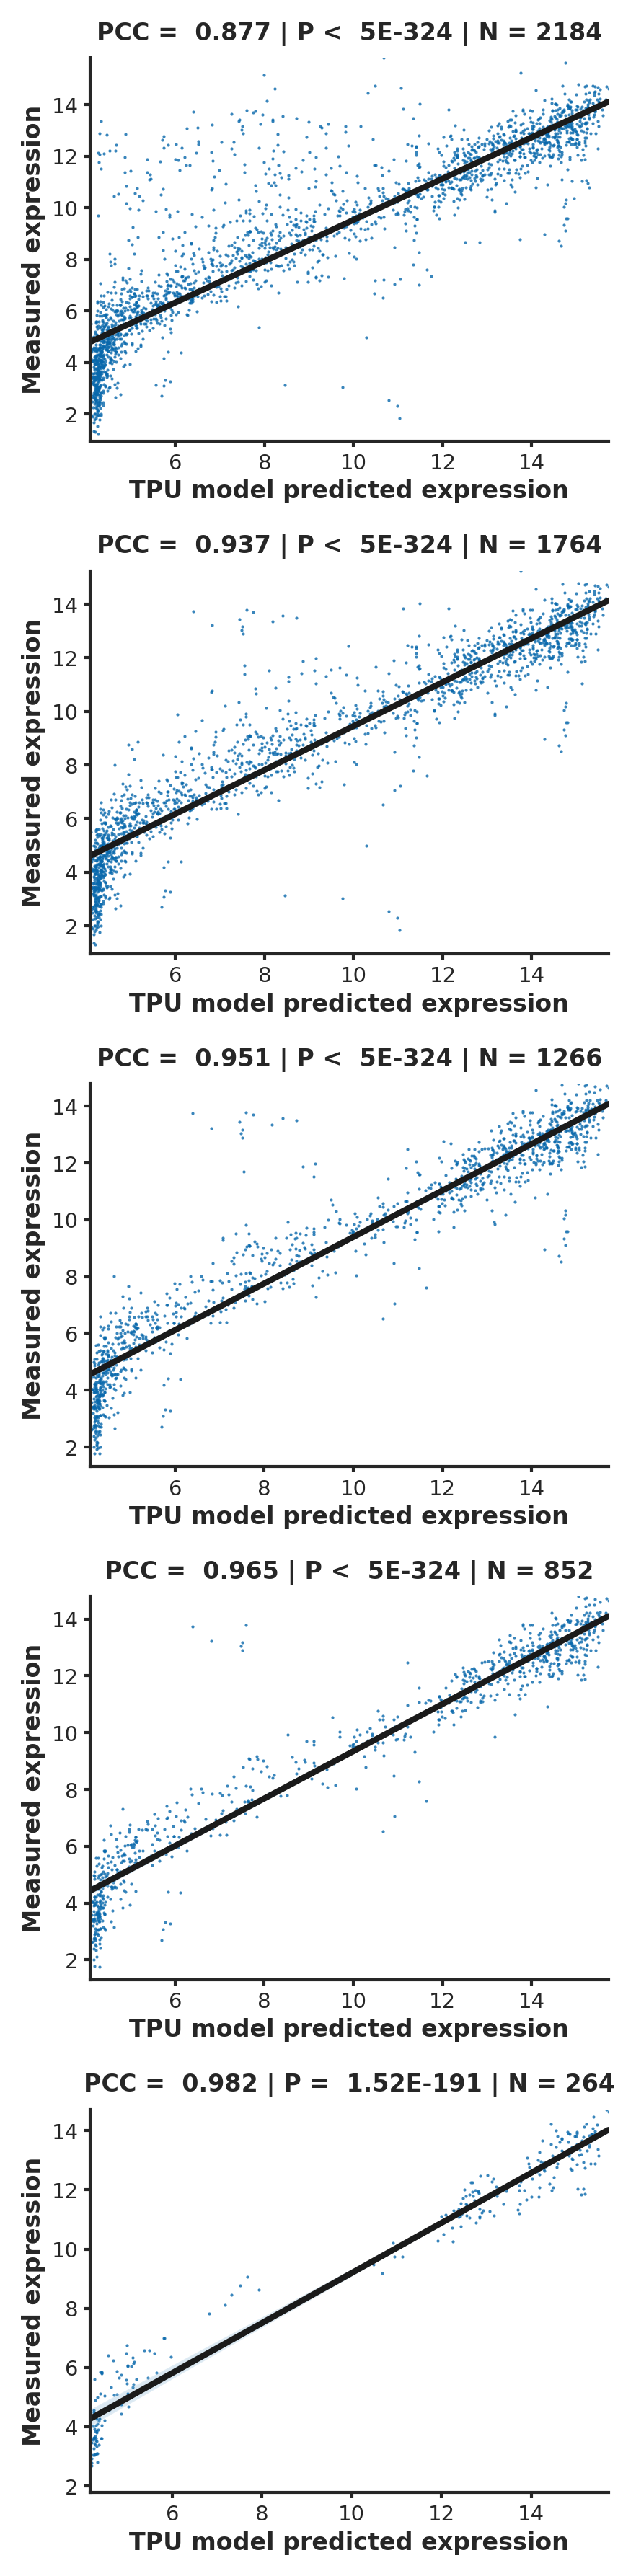

In [6]:
import glob
file_list = glob.glob('../../../data/test_data/all_gini_trajectories/*')[:-1]


model_name = 'TPU model'

fig_file = model_name+" prediction_performance_gini"

fig=plt.figure(figsize=(12/4,12) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


index = 1
for i in [-1,1,-2,2,0]: 
    plt.subplot(5, 1, index)
    index = index+1
    gini_df = pd.read_csv( file_list[i], 
                          sep='\t')
    sequences = population_add_flank(list(gini_df['N80seq'].values))
    expressions = gini_df['meanEL_NBT_S288CdU_YPD'].values
    predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)
    x = list(predicted_expressions)
    y = expressions

    
    
    
    
    
    r = scipy.stats.pearsonr(x ,y )
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':2} ,
                color= '#0868ac', robust = 1 )



    ax = plt.gca()
    #ax.get_legend().remove()


    ax.set_xlabel(model_name + " predicted expression")
    ax.set_ylabel("Measured expression")
    if (r[1] ==0.0) :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
    else :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


    plt.setp(ax.artists, edgecolor = 'k')
    plt.setp(ax.lines, color='k')
    #plt.setp(ax.lines, linewidth=1.5)

    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    #ax.set_xlim(xmin=-8,xmax=8)
    #ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()